## Quantum Hadamard edge detector

In this notebook we provide an implementation of the Quantum Hadamard Edge Detection (QHED) algorithm [1], for 2 images and 3D volumes.  We provide an implementation on Qiskit, following the tutorial [2], which is meant to run on real hardware or fake simulators. We also provide an implementation with pytorch, which is optimized to work faster in quantum simulation (CPUs and GPUs).


[1]  Yao, Xi-Wei, et al. "Quantum image processing and its application to edge detection: theory and experiment." Physical Review X 7.3 (2017): 031041.

[2] Quantum Edge Detection - QHED Algorithm on Small and Large Images https://qiskit.org/textbook/ch-applications/quantum-edge-detection.html#Quantum-Hadamard-Edge-Detection-(QHED)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from torch import device, tensor, zeros
from torch.utils.data import DataLoader
import torch

from data.data_reader import Dataset_MLHDF
from data.img_util import GaussianFilter, Voxelizer3D
from ingenii_quantum.hybrid_networks.edge_detection import EdgeDetector2D, EdgeDetector3D

## 2D example

We first provide the code to run a 2D image with Qiskit. This code is meant to be run in a real quantum computer or a fake provider. We use the same images as in the tutorial [2]. Since the image is quite large ($256 \times 256$), we can not process the whole image with the current hardware (or quantum simulation). For this reason, we split the image into ($4\times 4$) blocks, and apply the edge algorithm to each block. Let's start by visualizing the image.

Raw Image info: (366, 366, 4)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


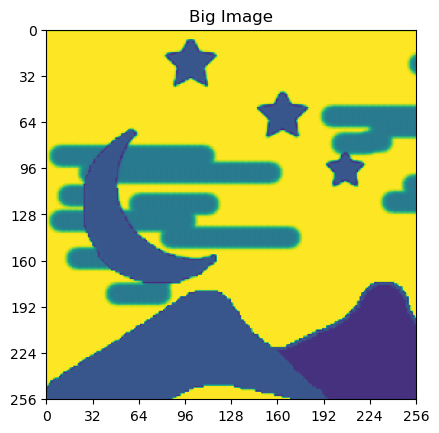

In [2]:
from PIL import Image

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing

# Load the image from filesystem
image_raw = np.array(Image.open('images/edge-detection.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = np.array([
    [
        image_raw[i][j][0] / 255
        for j in range(image_size)
    ]
    for i in range(image_size)
])
            
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

### Run with Qiskit code

In [3]:
data =  np.array(image).reshape(1, image_size, image_size)
edge_detector = EdgeDetector2D(size=4, shots=2**10, backend='aer_simulator')
reverted_image = edge_detector.run(
    data, tol=1e-5, reduce=False, verbose=True).reshape(image_size, image_size)

100%|██████████| 4096/4096 [01:30<00:00, 45.18it/s]


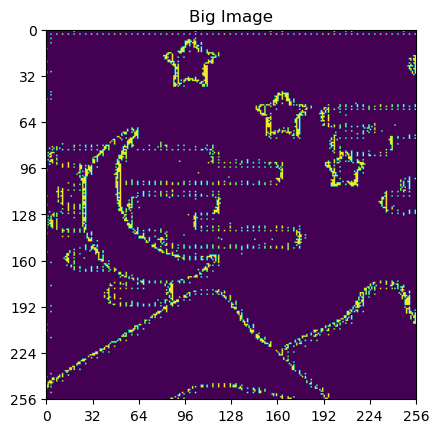

In [4]:
# Display the image
plt.title('Big Image')
plt.xticks(range(0, reverted_image.shape[0]+1, 32))
plt.yticks(range(0, reverted_image.shape[1]+1, 32))
plt.imshow(reverted_image, extent=[0, reverted_image.shape[0], reverted_image.shape[1], 0], cmap='viridis')
plt.show()

## Run with pytorch

In [5]:
data = tensor(image).reshape(1, image_size, image_size)
edge_detector = EdgeDetector2D(size=4, backend='torch')
reverted_image = edge_detector.run(
    data, tol=1e-2, reduce=False, verbose=True).reshape(image_size, image_size)

Total execution time:  0.013002634048461914


c:\Users\laiad\Ingenii, Inc\Ingenii LLC - Documents\Research\Library\ingenii-quantum-hybrid-networks - v0.3\examples\edge_detection.py:243: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(normalized_flatten, dtype=torch.float32),


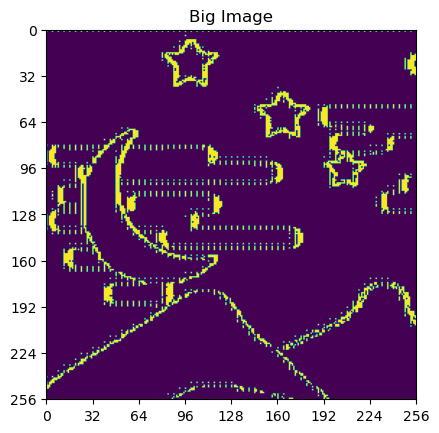

In [6]:
# Display the image
plt.title('Big Image')
plt.xticks(range(0, reverted_image.shape[0]+1, 32))
plt.yticks(range(0, reverted_image.shape[1]+1, 32))
plt.imshow(reverted_image, extent=[0, reverted_image.shape[0], reverted_image.shape[1], 0], cmap='viridis')
plt.show()

The edge detection algorithm works! Notice that running the algorithm with the pytorch backend is much faster than running it with quantum simulation in the Qiskit backend. Also, the results using the qiskit backend depend on the number of shots of the experimet, that should be large enough to produce good results. 

Another parameter of the algorithm is the tolerance *tol*. It measures how big does the gradient need to be so that it is considered an edge. This value should be tuned for different datasets, so it should be set by the user.

## Application to 3D data

Now we show an example of a 3D volume, processed from the PDBBind dataset for protein-ligand prediction.

## Load the data

We begin by loading some samples of the data and visualizing them

In [7]:
dataset = Dataset_MLHDF(
    'data/pdbbind2016_core_test.hdf', 1, 'data/core_test_3dnn.csv',
    is_crystal=True, rmsd_weight=0, rmsd_thres=20
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=True)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

c:\Users\laiad\anaconda3\envs\Qiskit1x\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
vol_batch = zeros((1,19,48,48,48)).float().to(device("cpu"))
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)
    break

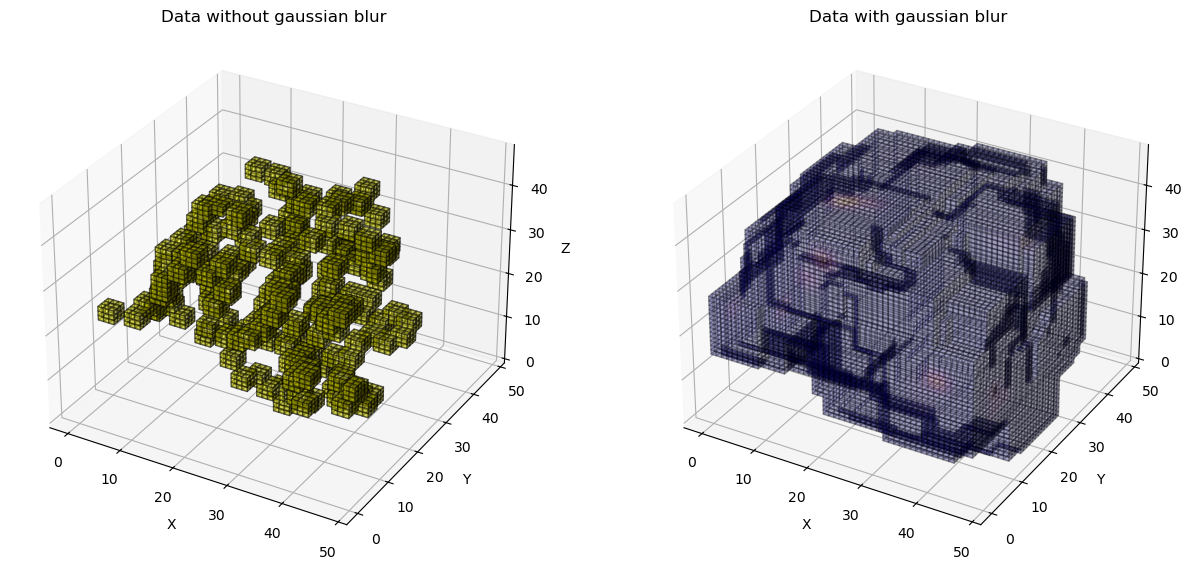

In [9]:
# We show an example data sample with and without gaussian blur
example_data_sample_gaussian_blur = vol_batch_gaus[0][1].numpy()
example_data_sample = vol_batch[0][1].numpy()

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.voxels(example_data_sample, facecolors='yellow', alpha=0.4, edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Data without gaussian blur')

colors = plt.cm.plasma(example_data_sample_gaussian_blur)
ax2.voxels(example_data_sample_gaussian_blur, facecolors=colors, alpha=0.2, edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Data with gaussian blur')

plt.show()

## Run with pytorch backend

In [10]:
edge_detector = EdgeDetector3D(size=16, backend='torch')

In [11]:
data = vol_batch_gaus
data_processed = edge_detector.run(data, num_filters=1, tol=3e-3, reduce=False, verbose=True)

Total execution time:  1.957998514175415


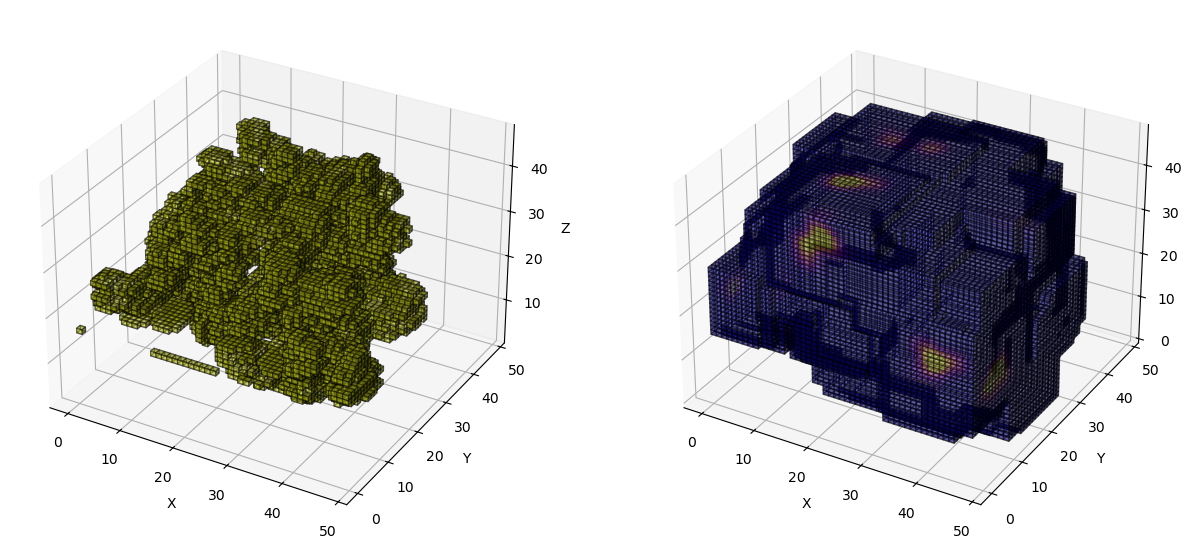

In [12]:
d2 = data[0, 10].numpy()
d = data_processed[0, 10].numpy()

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d, facecolors=colors, alpha=0.4, edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

colors = plt.cm.plasma(d2)
ax2.voxels(d2, facecolors=colors, alpha=0.4, edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

## Run with Qiskit backend

Now we run the code with Qiskit backend in quantum simulation. We see that the execution time is much longer than running the algorithm with pytorch. 

In [13]:
edge_detector = EdgeDetector3D(size=4, shots=2**10)

In [14]:
data = vol_batch_gaus
data_processed = edge_detector.run(data.numpy().copy(), num_filters=3, tol=3e-3, reduce=False, verbose=True)

  0%|          | 0/32832 [00:00<?, ?it/s]

100%|██████████| 32832/32832 [03:11<00:00, 171.33it/s] 


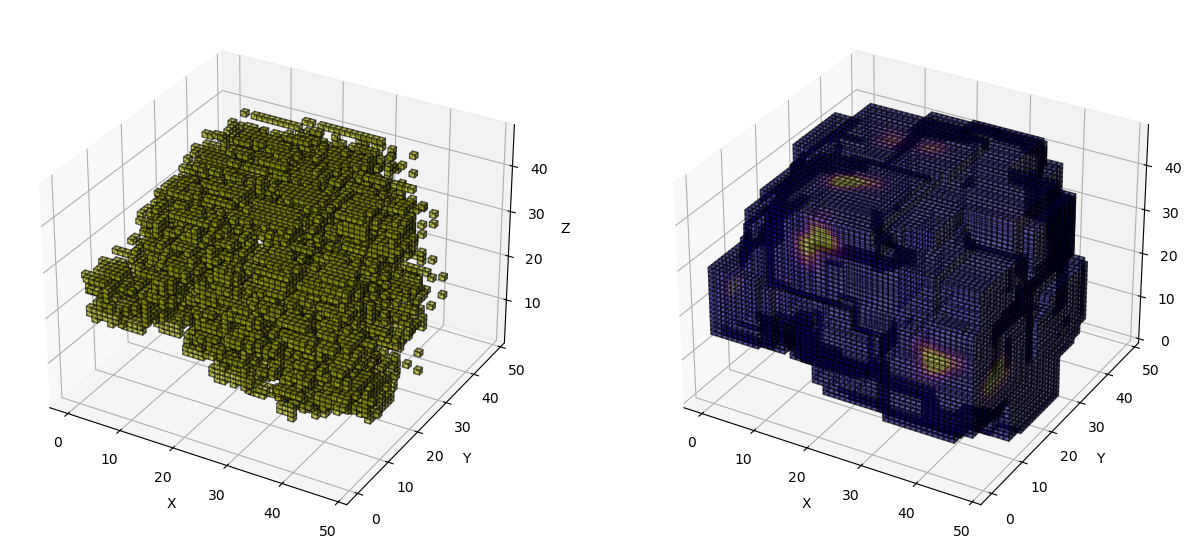

In [15]:
d2 = data[0, 10].numpy()
d = data_processed[0, 10]

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1 ,2, 2, projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d, facecolors=colors, alpha=0.4, edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

colors = plt.cm.plasma(d2)
ax2.voxels(d2, facecolors=colors, alpha=0.4, edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()